# Training DM21.

Now we will add a non-exact-exchange term to the functional we learned on the 01 example in this folder.

In [1]:
from optax import adam, apply_updates
from jax.lax import stop_gradient

import grad_dft as gd

from tqdm import tqdm


from jax.config import config
config.update("jax_enable_x64", True)

/Users/pablo.casares/miniforge3/envs/graddft/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Instructions for updating:
non-resource variables are not supported in the long term


We start by initializing the PySCF `molecule` object again

In [2]:
# First we define a molecule, using pyscf:
from pyscf import gto, dft

mol = gto.M(atom="H 0 0 0; F 0 0 1.1")

grids = dft.gen_grid.Grids(mol)
grids.level = 2
grids.build()

mf = dft.UKS(mol)
mf.grids = grids
ground_truth_energy = mf.kernel()

converged SCF energy = -98.2455025940388  <S^2> = 1.9548807e-12  2S+1 = 1


The difference now, however, is that we will indicate a non-empty `omegas` list, which will define the values of $\omega$ in the range-separated Coulomb kernel $\frac{\text{erf}(\omega|r-r'|)}{|r-r'|}$.
Note that $\omega = 0$ indicates the usual Coulomb kernel $\frac{1}{|r-r'|}$.

In [3]:
molecule = gd.molecule_from_pyscf(mf, omegas=[0.0, 0.4])

Now we can import the DM21 functional and its weights.

In [4]:
functional = gd.DM21()
params = functional.generate_DM21_weights()

Next we show three different ways to compute the energy. First, we can use the `.energy()` method of the functional object.

In [5]:
# Or alternatively, we can use an already prepared function that does everything for us
predicted_energy = functional.energy(params, molecule)
print("Predicted_energy:", predicted_energy)

Predicted_energy: -98.88475055003353


Second, we can use the `molecule_predictor`, which will also return the correct Fock matrix; as in this case there are terms that cannot be computed via autodifferentiation.

In [6]:
predict = gd.molecule_predictor(functional)
predicted_energy, grads = predict(params, molecule)
print("Predicted_energy:", predicted_energy)

Predicted_energy: -98.88475055003353


Third, we can check that the results correspond to the step-by-step computation of the energy.

In [7]:
# We generate the input densities from the molecule we created before
grad_densities = functional.energy_densities(molecule)
nograd_densities = stop_gradient(functional.nograd_densities(molecule))
densities = functional.combine_densities(grad_densities, nograd_densities)

# We now generated the inputs to the coefficients nn
grad_cinputs = functional.coefficient_inputs(molecule)
nograd_cinputs = stop_gradient(functional.nograd_coefficient_inputs(molecule))
coefficient_inputs = functional.combine_inputs(grad_cinputs, nograd_cinputs)

# We can use this features to compute the energy by parts
energy = functional.xc_energy(params, molecule.grid, coefficient_inputs, densities)
energy += molecule.nonXC()

print("Energy by parts:", energy)

Energy by parts: -98.88475055003353


## Training the functional

Now let us train the functional. We start initializing the optimizer.

In [8]:
# Then, we define the optimizer
learning_rate = 1e-5
momentum = 0.9
tx = adam(learning_rate=learning_rate, b1=momentum)
opt_state = tx.init(params)

# and implement the optimization loop
n_epochs = 15

Next, we select the predictor and the loss function.

In [9]:
predict = gd.make_non_scf_predictor(functional)

Finally we run the training loop.

In [10]:
losses = []
for iteration in tqdm(range(n_epochs), desc = 'iterations'):
    (loss, predicted_energy), grads = gd.simple_energy_loss(
        params, predict, molecule, ground_truth_energy
    )
    print("Iteration", iteration, "Predicted energy:", predicted_energy)
    losses.append(loss)
    updates, opt_state = tx.update(grads, opt_state, params)
    params = apply_updates(params, updates)

iterations:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration 0 Predicted energy: -98.88475055003353


iterations:  13%|█▎        | 2/15 [00:20<02:13, 10.23s/it]

Iteration 1 Predicted energy: -98.85137783207568


iterations:  20%|██        | 3/15 [00:31<02:04, 10.38s/it]

Iteration 2 Predicted energy: -98.81918515974253


iterations:  27%|██▋       | 4/15 [00:40<01:49,  9.98s/it]

Iteration 3 Predicted energy: -98.78806377550379


iterations:  33%|███▎      | 5/15 [00:50<01:39,  9.91s/it]

Iteration 4 Predicted energy: -98.75789468973491


iterations:  40%|████      | 6/15 [00:56<01:19,  8.81s/it]

Iteration 5 Predicted energy: -98.72856046786019


iterations:  47%|████▋     | 7/15 [01:03<01:04,  8.12s/it]

Iteration 6 Predicted energy: -98.69996169212077


iterations:  53%|█████▎    | 8/15 [01:11<00:57,  8.15s/it]

Iteration 7 Predicted energy: -98.67200346962056


iterations:  60%|██████    | 9/15 [01:22<00:53,  8.85s/it]

Iteration 8 Predicted energy: -98.6446024706614


iterations:  67%|██████▋   | 10/15 [01:33<00:47,  9.49s/it]

Iteration 9 Predicted energy: -98.61769399463448


iterations:  73%|███████▎  | 11/15 [01:46<00:42, 10.56s/it]

Iteration 10 Predicted energy: -98.59121950506238


iterations:  80%|████████  | 12/15 [01:59<00:34, 11.42s/it]

Iteration 11 Predicted energy: -98.56513479654217


iterations:  87%|████████▋ | 13/15 [02:10<00:22, 11.25s/it]

Iteration 12 Predicted energy: -98.53941111352529


iterations:  93%|█████████▎| 14/15 [02:23<00:11, 11.75s/it]

Iteration 13 Predicted energy: -98.5140372380046


iterations: 100%|██████████| 15/15 [02:37<00:00, 10.50s/it]

Iteration 14 Predicted energy: -98.48902020770015


Save the checkpoints.

In [11]:
# We can save the checkpoint back.
functional.save_checkpoints(params, tx, step=n_epochs)

We can also plot the results.

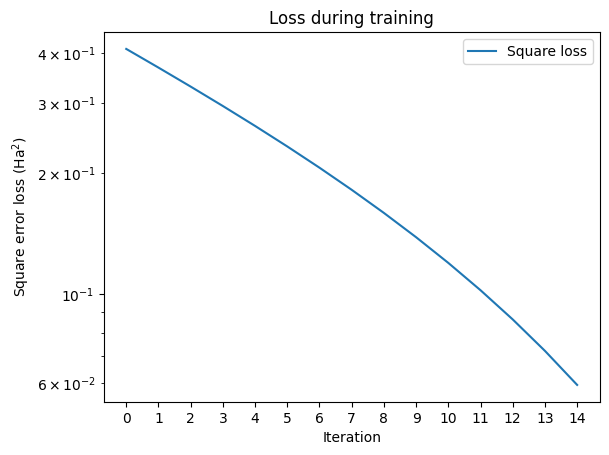

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(losses, label="Square loss")
ax.set_xlabel("Iteration")
ax.set_ylabel(r"Square error loss (Ha$^2$)")

# Set x labels at integer values
import numpy as np

ax.set_xticks(np.arange(0, n_epochs, 1.0))

ax.set_title("Loss during training")

ax.set_yscale("log")

ax.legend()

## Self-consistent iterative procedure

We first load the checkpoint.

In [13]:
train_state = functional.load_checkpoint(
    tx, ckpt_dir="ckpts/checkpoint_" + str(n_epochs) + "/", step=n_epochs
)
params = train_state.params
tx = train_state.tx
opt_state = tx.init(params)

Then, we initialize the self-consistent iteration.

In [14]:
scf_iterator = gd.make_scf_loop(functional, verbose=2, cycles=5)

and finally we run it.

In [15]:
# Finally, we create and implement the self-consistent loop.
modified_molecule = scf_iterator(params, molecule)

print(f"The predicted energy is {modified_molecule.energy}")


SCF not converged.
SCF energy = -98.1437213127202
cycle: 0, energy: -9.8464435e+01, energy difference: 6.0667e-05, norm_gradient_orbitals: 5.07e-03, seconds: 9.6e+00
cycle: 1, energy: -9.8464482e+01, energy difference: 4.7335e-05, norm_gradient_orbitals: 1.41e-03, seconds: 7.2e+00
cycle: 2, energy: -9.8464470e+01, energy difference: 1.2183e-05, norm_gradient_orbitals: 6.89e-03, seconds: 7.2e+00
cycle: 3, energy: -9.8464511e+01, energy difference: 4.0626e-05, norm_gradient_orbitals: 5.99e-03, seconds: 8.2e+00
cycle: 4, energy: -9.8464477e+01, energy difference: 3.3141e-05, norm_gradient_orbitals: 6.45e-03, seconds: 7.3e+00
cycle: 5, predicted energy: -9.8464477e+01, energy difference: 3.3141e-05, norm_gradient_orbitals: 6.45e-03
The predicted energy is -98.46447747758238


Note that in this case we cannot use the differentiable scf iterator, as the functional include exact exchange terms that cannot be computed via autodifferentiation.